In [1]:
import torch
import torch.nn as nn
from main.dataset import XrayDataset
from torch.utils.data import DataLoader
from main.transform import train_transform
from main.multimodel import Multimodel

In [2]:
csv_path = r"C:\Users\Acer\Desktop\Office\X-ray-NormalVsAbnormal\Normal-abnormal-multimodel\test.csv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dataset = XrayDataset(img_dir='', csv_path=csv_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

In [29]:
for image, label, bbox, has_bbox in train_loader:
    image, label, bbox, has_bbox = image, label, bbox, has_bbox
    break

In [30]:
image.shape, label.shape, bbox, has_bbox

(torch.Size([4, 3, 224, 224]),
 torch.Size([4]),
 tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
 tensor([False, False, False, False]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.4831376].


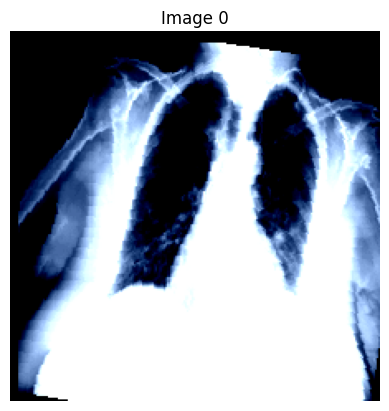

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.1345534].


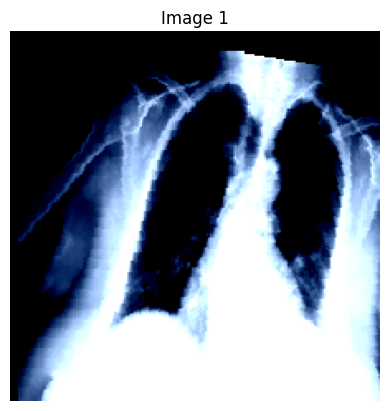

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.907974].


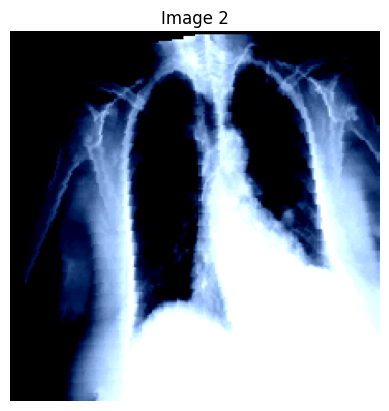

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


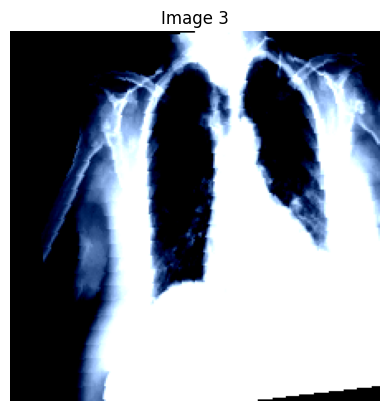

In [6]:
import matplotlib.pyplot as plt

# batch: torch.Tensor of shape [4, 3, 224, 224]
batch = image.cpu()   # make sure it's on CPU

for i in range(batch.shape[0]):
    img = batch[i].permute(1, 2, 0)  # CHW → HWC

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i}")
    plt.show()


In [7]:
model = Multimodel().to(device)

c:\Users\Acer\anaconda3\envs\X-ray-NormalVsAbnormal\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Acer\anaconda3\envs\X-ray-NormalVsAbnormal\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
image = image.to(device)
label = label.to(device)
bbox  = bbox.to(device)
has_bbox = has_bbox.to(device)

In [15]:
bbox

tensor([[   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [1884., 1635., 1916., 1709.]])

In [9]:
criterian = nn.BCEWithLogitsLoss()
bbox_loss = nn.MSELoss()

In [10]:
# model

In [11]:
cls_logits, bbox_preds = model(image, has_bbox, return_bbox=True)

In [12]:
cls_logits, bbox_preds

(tensor([[-0.0110],
         [ 0.1670],
         [ 0.0957],
         [-0.0791]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0000, -0.0000,  0.0000, -0.0000],
         [-0.0000, -0.0000,  0.0000, -0.0000],
         [-0.0000, -0.0000,  0.0000,  0.0000],
         [-0.0945, -0.2669,  0.0087,  0.0040]], grad_fn=<MulBackward0>))

In [14]:
cls_logits = model(image)
cls_logits

tensor([[-0.1029],
        [ 0.0200],
        [ 0.0062],
        [ 0.0836]], grad_fn=<AddmmBackward0>)

In [16]:
has_bbox.unsqueeze(1).float() 

tensor([[1.],
        [1.],
        [1.],
        [0.]])

In [17]:
if has_bbox is not None:
    print('yes')

yes


In [31]:
cls_logits.shape, label.shape

(torch.Size([4, 1]), torch.Size([4]))

In [22]:
label

tensor([0., 0., 0., 1.])

In [26]:
preds = (torch.sigmoid(cls_logits).squeeze(1) > 0.5).float()
preds

tensor([0., 1., 1., 1.])

In [27]:
total_correct = (preds == label).sum().item()

In [28]:
preds == label

tensor([ True, False, False,  True])